In [2]:
import pandas as pd
import numpy as np
from transformers import pipeline
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nlp


import torch
import torch.nn.functional as F

In [3]:
from datasets import load_dataset

ds_original_from_hf = load_dataset("poem_sentiment")

Found cached dataset poem_sentiment (/home/raj/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
ds_original_from_hf

DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 892
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 104
    })
})

In [5]:
train_ds = ds_original_from_hf['train']
train_ds

Dataset({
    features: ['id', 'verse_text', 'label'],
    num_rows: 892
})

In [6]:
label_names = ds_original_from_hf['train'].features['label'].names

In [7]:
ds_original_from_hf['train'].features

{'id': Value(dtype='int32', id=None),
 'verse_text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'positive', 'no_impact', 'mixed'], id=None)}

In [8]:
ds_original_from_hf['train'].features['label']

ClassLabel(names=['negative', 'positive', 'no_impact', 'mixed'], id=None)

In [9]:
label_names

['negative', 'positive', 'no_impact', 'mixed']

In [10]:
train_ds[0]

{'id': 0,
 'verse_text': 'with pale blue berries. in these peaceful shades--',
 'label': 1}

In [11]:
train_ds.column_names

['id', 'verse_text', 'label']

In [12]:
train = pd.DataFrame(ds_original_from_hf['train'])
train.head()

,id,verse_text,label
0,0,with pale blue berries. in these peaceful shad...,1
1,1,"it flows so long as falls the rain,",2
2,2,"and that is why, the lonesome day,",0
3,3,"when i peruse the conquered fame of heroes, an...",3
4,4,of inward strife for truth and liberty.,3


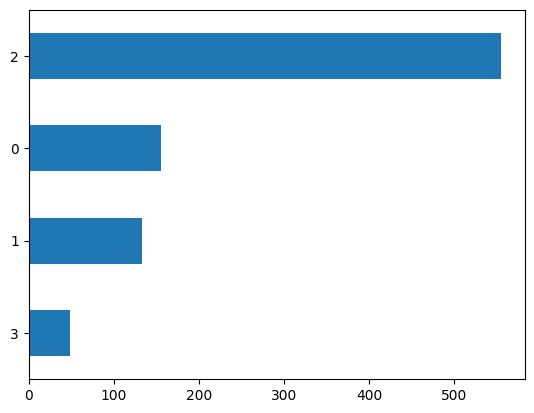

In [13]:
train['label'].value_counts(ascending=True).plot.barh()
plt.show()

In [14]:
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [15]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [16]:
tokenizer.pretrained_init_configuration

{'distilbert-base-uncased': {'do_lower_case': True},
 'distilbert-base-uncased-distilled-squad': {'do_lower_case': True},
 'distilbert-base-cased': {'do_lower_case': False},
 'distilbert-base-cased-distilled-squad': {'do_lower_case': False},
 'distilbert-base-german-cased': {'do_lower_case': False},
 'distilbert-base-multilingual-cased': {'do_lower_case': False}}

In [17]:
tokenizer.get_vocab()

{'andover': 29463,
 '##rito': 28414,
 'purchases': 17402,
 'spot': 3962,
 'murders': 9916,
 '##ulated': 8898,
 '[unused917]': 922,
 'celine': 24550,
 '[unused341]': 346,
 'none': 3904,
 'urging': 14328,
 'undergo': 13595,
 'lilly': 14765,
 'prescribed': 16250,
 'vanishing': 24866,
 '##車': 30480,
 '##omi': 20936,
 'ད': 1428,
 '##ha': 3270,
 'singh': 5960,
 'mclean': 17602,
 'inform': 12367,
 '##grass': 19673,
 'cochrane': 22329,
 '##uder': 29190,
 'palace': 4186,
 'gaa': 19930,
 'fashioned': 13405,
 'authoritarian': 27246,
 'karachi': 15381,
 'attend': 5463,
 'suv': 15620,
 'adrian': 7918,
 'violinist': 16609,
 '##watch': 18866,
 '##tya': 21426,
 'ornamental': 18200,
 'radicals': 23618,
 'italiana': 28059,
 'inherit': 22490,
 'equations': 11380,
 'forerunner': 23993,
 'inclusive': 18678,
 'drugs': 5850,
 'confines': 25722,
 'exercising': 28428,
 '##cho': 9905,
 'adi': 27133,
 '##sser': 18116,
 'commotion': 23960,
 'catch': 4608,
 '##51': 22203,
 'consulate': 19972,
 'accessory': 25339,


In [18]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [19]:
tokenizer.vocab_size

30522

In [20]:
def tokenize_function(batch):
    return tokenizer(batch['verse_text'],padding=True,truncation=True)

In [21]:
print(tokenize_function(ds_original_from_hf['train'][:2]))

{'input_ids': [[101, 2007, 5122, 2630, 22681, 1012, 1999, 2122, 9379, 13178, 1011, 1011, 102], [101, 2009, 6223, 2061, 2146, 2004, 4212, 1996, 4542, 1010, 102, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]}


In [22]:
ds_pretrained_fearures_encoded = ds_original_from_hf.map(tokenize_function,batched=True,batch_size=None)

Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099/cache-4ac3eb3a21254e67.arrow
Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099/cache-6932fa8be1dbbf60.arrow
Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099/cache-dcd8a476658e956d.arrow


In [23]:
ds_pretrained_fearures_encoded['train'].column_names

['id', 'verse_text', 'label', 'input_ids', 'attention_mask']

Using Pretrained Model - DistilBERT

In [24]:
from transformers import AutoModel

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
def get_hidden_state(batch):
    inputs = {k: v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names }
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {'hidden_state': last_hidden_state[:,0].cpu().numpy() }

ds_pretrained_fearures_encoded.set_format('torch',columns = [ 'label', 'input_ids', 'attention_mask'])

In [26]:
ds_pretrained_fearures_encoded['train'].features

{'id': Value(dtype='int32', id=None),
 'verse_text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'positive', 'no_impact', 'mixed'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [27]:
pretrained_hidden_states = ds_pretrained_fearures_encoded.map(get_hidden_state,batched=True)

Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099/cache-fb90ce617768146a.arrow
Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099/cache-00dafe518ee71e68.arrow
Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099/cache-c1f6e7e572c81340.arrow


In [28]:
pretrained_hidden_states['train']

Dataset({
    features: ['id', 'verse_text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 892
})

In [29]:
X_train = np.array(pretrained_hidden_states['train']['hidden_state'])
X_valid = np.array(pretrained_hidden_states['validation']['hidden_state'])

y_train = np.array(pretrained_hidden_states['train']['label'])
y_valid = np.array(pretrained_hidden_states['validation']['label'])

In [30]:
X_train

array([[-0.22319107, -0.13402359, -0.03985157, ..., -0.13194129,
         0.28541842,  0.1294578 ],
       [-0.22522773, -0.13816187,  0.03874098, ..., -0.00618832,
         0.23927002,  0.35466564],
       [-0.14576909,  0.02673087, -0.06139479, ...,  0.04230488,
         0.40021536,  0.19074394],
       ...,
       [-0.15839648,  0.06465053, -0.134851  , ..., -0.09434574,
         0.15932408,  0.13212441],
       [-0.30197528,  0.03574481, -0.2639341 , ..., -0.09008646,
         0.4321668 ,  0.3521736 ],
       [-0.08587637,  0.04959171,  0.00788689, ..., -0.21295595,
         0.37026837,  0.18545856]], dtype=float32)

In [31]:
X_train.shape  #(batch_size,out_feature)

(892, 768)

In [32]:
# ! pip install umap-learn

In [33]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_train_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components = 2, metric = 'cosine').fit(X_train_scaled)

/home/raj/.conda/envs/raj/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/raj/.conda/envs/raj/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/raj/.conda/envs/raj/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDepr

In [34]:
mapper

UMAP(angular_rp_forest=True, metric='cosine', tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [35]:
df_embedded_from_hidden = pd.DataFrame(mapper.embedding_, columns=['X','Y'])

df_embedded_from_hidden['label'] = y_train

display(df_embedded_from_hidden.head())

,X,Y,label
0,12.895674,7.019976,1
1,8.545488,6.146675,2
2,10.701999,4.199473,0
3,7.815099,5.986995,3
4,11.387780,6.370640,3


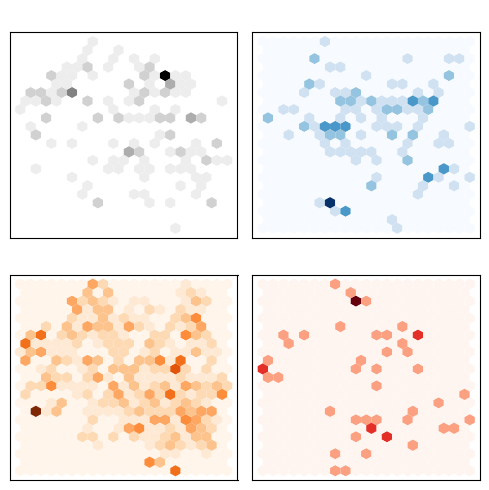

In [36]:
fig, axes = plt.subplots(2,2,figsize=(5,5))

axes = axes.flatten()

cmaps = ['Greys', "Blues", "Oranges", "Reds", "Purples", "Greens"]

#Labels name of ds_original_from_hf
labels = ds_original_from_hf["train"].features["label"].names

#separate
for i,(label, cmap) in enumerate(zip(labels, cmaps)):
    df_embedding_subplot = df_embedded_from_hidden.query(f"label == {i}")
    axes[i].hexbin(df_embedding_subplot["X"], df_embedding_subplot["Y"], cmap=cmap,
                  gridsize= 20, linewidths=(0,))
    axes[i].set_title(label, color='white')
    axes[i].set_xticks([]),axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

In [37]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train,y_train)

print("Logistic Regression Score",lr_clf.score(X_valid,y_valid))

Logistic Regression Score 0.780952380952381


In [38]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')

dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_valid, y_valid))

0.6571428571428571


In [39]:
from transformers import AutoModelForSequenceClassification

num_labels = len(ds_original_from_hf['train'].features['label'].names)

In [40]:
num_labels

4

In [41]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels=num_labels)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.we

In [42]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [43]:
from sklearn.metrics import accuracy_score,f1_score

def compute_metric(pred):
    # print('here')
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels,preds,average='weighted')
    acc = accuracy_score(labels,preds)
    return {'accuracy':acc,'f1':f1}

In [44]:
from transformers import Trainer,TrainingArguments

batch_size = 12
logging_steps = len(ds_pretrained_fearures_encoded['train']) // batch_size

model_name = f"{model_ckpt}-finetune-poem"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False, 
    log_level="error"
)

In [50]:
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metric,
                  train_dataset = ds_pretrained_fearures_encoded['train'],
                  eval_dataset = ds_pretrained_fearures_encoded["validation"],
                  tokenizer = tokenizer
                  )
trainer.train()

/home/raj/.conda/envs/raj/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/raj/.conda/envs/raj/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.458808,0.876190,0.871567
2,0.310200,0.454175,0.866667,0.856559


/home/raj/.conda/envs/raj/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=76, training_loss=0.31329036778525304, metrics={'train_runtime': 7.0658, 'train_samples_per_second': 252.483, 'train_steps_per_second': 10.756, 'total_flos': 12924311538432.0, 'train_loss': 0.31329036778525304, 'epoch': 2.0})

In [51]:
preds_output = trainer.predict(ds_pretrained_fearures_encoded['validation'])

/home/raj/.conda/envs/raj/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [52]:
preds_output.metrics

{'test_loss': 0.454174667596817,
 'test_accuracy': 0.8666666666666667,
 'test_f1': 0.8565594165594167,
 'test_runtime': 0.2051,
 'test_samples_per_second': 511.823,
 'test_steps_per_second': 24.373}

In [48]:
from torch.nn.functional import cross_entropy

def forward_pass_with_loss_and_label(batch):
    """
    This function performs a forward pass through the model, computes the loss and predicts labels.

    Args:
        batch (Dict[str, torch.Tensor]): Dictionary containing the model inputs and labels.

    Returns:
        Dict[str, Union[torch.Tensor, np.ndarray]]: Dictionary with the computed loss and predicted labels.
    """
    # Move the model inputs to the GPU (if available)
    # This is necessary because the model itself is likely on the GPU
    # Only model input names are included, other keys (e.g., 'labels') are ignored
    inputs = {k: v.to(device) for k, v in batch.items() 
              if k in tokenizer.model_input_names }
    
    # Ensures that gradients are not computed, saving memory
    with torch.no_grad():
        # Forward pass through the model
        output = model(**inputs)

        # Predict labels by selecting the argmax of the logits along the last dimension
        pred_label = torch.argmax(output.logits, axis=-1)

        # Compute the cross-entropy loss between the logits and true labels
        # reduction='none' ensures that we get a loss value for each sample, not the mean loss
        loss = cross_entropy(output.logits, batch['label'].to(device), reduction='none')

    # Returns the loss and predicted labels as numpy arrays
    # These are moved to the CPU first, because numpy cannot handle GPU tensors
    return {'loss': loss.cpu().numpy(), 
            'predicted_label': pred_label.cpu().numpy()}

In [53]:
ds_pretrained_fearures_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
ds_pretrained_fearures_encoded["validation"] = ds_pretrained_fearures_encoded["validation"].map(
    forward_pass_with_loss_and_label, batched=True, batch_size=16)

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

In [54]:
ds_pretrained_fearures_encoded['validation']

Dataset({
    features: ['id', 'verse_text', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
    num_rows: 105
})

In [56]:
ds_pretrained_fearures_encoded['validation']['loss']

tensor([0.0386, 0.7224, 1.0116, 0.9729, 0.1775, 1.8430, 4.5023, 0.1934, 0.0243,
        0.0398, 0.0223, 0.2314, 0.0474, 0.8134, 0.0543, 0.0248, 0.0352, 0.0257,
        0.0304, 0.0288, 0.0772, 0.0222, 2.4872, 0.0564, 0.0350, 0.0346, 0.0225,
        0.0398, 0.0234, 0.0442, 0.1031, 0.0221, 0.0559, 0.0218, 0.0341, 0.0222,
        0.0333, 0.0212, 0.0640, 0.0215, 0.0526, 4.1605, 0.1476, 0.0216, 0.0299,
        0.0188, 0.0961, 0.0568, 0.0223, 0.0205, 0.1933, 0.0258, 2.6808, 0.0337,
        0.0194, 0.1069, 0.0279, 0.1695, 0.2441, 0.3560, 0.0280, 0.0272, 0.1889,
        4.9367, 0.0222, 0.4575, 4.4138, 1.1877, 0.0832, 0.0226, 0.2046, 0.1615,
        0.1237, 3.6149, 0.0192, 0.0224, 0.0271, 0.0935, 0.1087, 0.1829, 3.3483,
        0.0213, 0.0342, 0.2132, 0.2007, 0.0337, 0.1017, 0.1855, 0.0227, 0.0223,
        0.0231, 0.2562, 0.0458, 1.7867, 0.0228, 0.1271, 0.0682, 1.9888, 0.0364,
        0.3677, 0.0265, 0.0267, 0.0734, 0.1607, 0.1951])

In [57]:
def label_int2str(row):
    return ds_original_from_hf['train'].features['label'].int2str(row)

ds_pretrained_fearures_encoded.set_format("pandas")

cols = ['verse_text', "label", "predicted_label", "loss"]

df_test = ds_pretrained_fearures_encoded["validation"][:][cols]

df_test["label"] = df_test["label"].apply(label_int2str)

df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

df_test.sort_values('loss', ascending=False ).head(10)

,verse_text,label,predicted_label,loss
63,on us lift up the light,positive,no_impact,4.936714
6,"taking and giving radiance, and the slopes",positive,no_impact,4.502286
66,i kin eat in peace.,positive,no_impact,4.413753
41,alone went the fair-armed gudrun to her flower...,positive,no_impact,4.160498
73,willis sneered:,negative,no_impact,3.614947
80,strong tarchon snatch’d and bore away his prize.,positive,negative,3.348338
52,"nor can express the love it knew,",negative,positive,2.680784
22,"let fall on her a rose-leaf rain of dreams,",positive,no_impact,2.487198
97,with the freedom of lakes and lands.,positive,no_impact,1.988813
5,"when the brow is cold as the marble stone,",negative,no_impact,1.843006


In [58]:
df_test.sort_values('loss', ascending=True ).head(10)

,verse_text,label,predicted_label,loss
45,"and i greet from far the ray,",no_impact,no_impact,0.018840
74,"from the bed of minnehaha,",no_impact,no_impact,0.019156
54,"might, looking up, see dian dip",no_impact,no_impact,0.019385
49,"no, truly.--i will see her; tell my tale,",no_impact,no_impact,0.020535
37,"why write i still all one, ever the same,",no_impact,no_impact,0.021162
81,"under the self-same bough, and heard as there",no_impact,no_impact,0.021314
39,"soon ez she gits out o' sight,",no_impact,no_impact,0.021468
43,"breathe deep, and start, to see him pass the d...",no_impact,no_impact,0.021616
33,that in their holes abed at close of day,no_impact,no_impact,0.021817
31,did all of them bow downward towards that side,no_impact,no_impact,0.022070
